# EM casing response

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 14

In [4]:
save_figures = True
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [5]:
run_simulations = True
directory = f"{path_to_data}/fields_casing_length"

In [6]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 100, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = np.r_[250, 500, 1000, 2000]

In [7]:
return_electrode_r = 250
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [8]:
csz = 5
npadz = 15
pf = 1.5

meshes = {}

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=11,
    csx2=25,
    domain_x=return_electrode_r
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = np.max(casing_l)/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

402480


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [9]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt), (3e-3, nt),
    (6e-3, nt), (1e-2, nt+40),
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max())

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back))} m")

1.0133200000000007
diffusion distance 4015.904466568961 m


[<PolarAxesSubplot:>, <AxesSubplot:xlabel='x', ylabel='z'>]

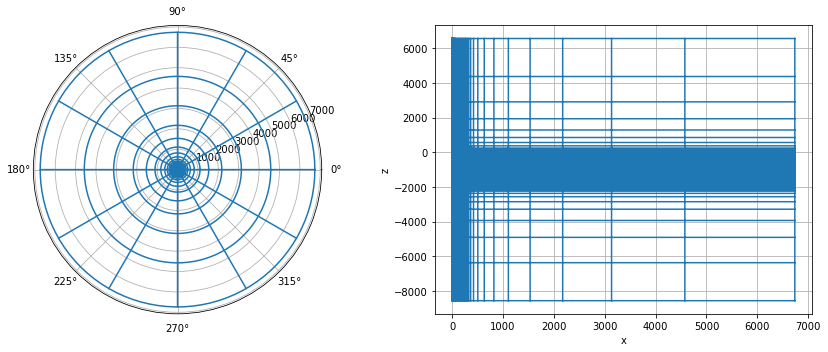

In [10]:
mesh.plot_grid()

In [11]:
models = {}
    
for l in casing_l: 
    
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -l)
    )
    inds_casing = inds_casing_x & inds_casing_z
    
    for mur in mur_casing:
        casing_conductivity = sigma_back * np.ones(mesh.n_cells)
        casing_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air
        casing_conductivity[inds_casing] = sigma_casing

        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        
        key = f"length_{l:1.0f}_mur_{mur:1.0f}"
        print(key)
        
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": casing_mur
        }

length_250_mur_1
length_250_mur_100
length_250_mur_200
length_500_mur_1
length_500_mur_100
length_500_mur_200
length_1000_mur_1
length_1000_mur_100
length_1000_mur_200
length_2000_mur_1
length_2000_mur_100
length_2000_mur_200


/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

(-2500.0, 10.0)

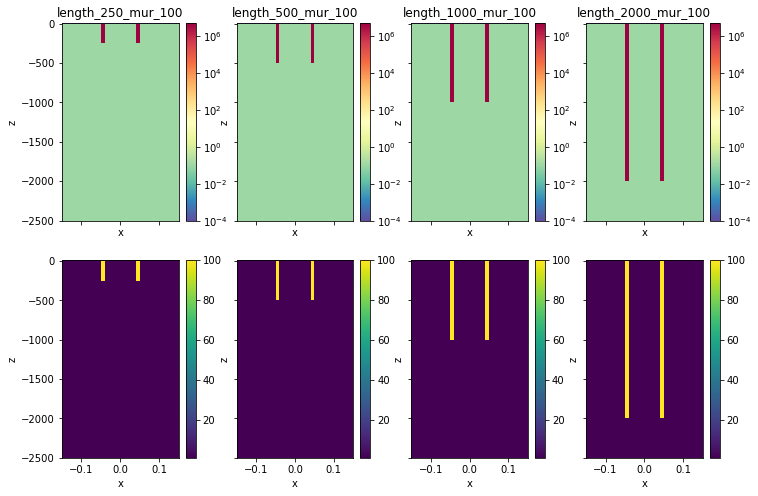

In [12]:
fig, ax = plt.subplots(2, len(casing_l), figsize=(len(casing_l)*3, 8), sharex=True, sharey=True)

mur_plot = 100
xlim = 0.15 * np.r_[-1, 1]
zlim = np.r_[-casing_l.max()*1.25, 10]

for i, l in enumerate(casing_l):
    key = f"length_{l}_mur_{mur_plot}"
    
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    casing_sim.view.plot_slice(
        mesh, models[key]["sigma"], pcolor_opts=pcolor_opts, ax=ax[0, i],
    )
    
    casing_sim.view.plot_slice(
        mesh, models[key]["mur"], ax=ax[1, i],
    )
    
    ax[0, i].set_title(key)
ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylim(zlim)

## set up the simulations

In [13]:
# top casing source 
src_theta = np.pi / 2. + mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


In [14]:
src = tdem.sources.LineCurrent([], location=src_locations)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DCurrentDensity(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=time_steps, 
#     verbose=True
)


In [15]:
def load_fields(name, conductivity, permeability):
    j = np.load(f"{directory}/fields_{name}.npy")
    sim.model = conductivity
    sim.mu = permeability
    f = sim.fieldsPair(sim)
    f[:, sim._fieldType + "Solution", :] = j
    return f

In [16]:
fields = {}

if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/times", sim.times)

In [17]:
if run_simulations:
    for key, val in models.items():
        t = time.time()
        print(f"starting {key}")

        sim.mu = mu_0 * val["mur"]
        print(f"     check max permeability: {sim.mu.max()/mu_0}")
        print(f"     check conductivities: {np.unique(val['sigma'])}")

        fields[key] = sim.fields(val["sigma"])
        np.save(f"{directory}/fields_{key}", fields[key][:, "jSolution", :])
        print(f" ... done. {time.time()-t:1.2e} s\n")
else: 
    for key, val in models.items():
        t = time.time()
        print(f"starting {key}")
        if key not in fields.keys(): 
            fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"]*mu_0)
        print(f" ... done. {time.time()-t:1.2e} s\n")

starting length_250_mur_1
     check max permeability: 1.0
     check conductivities: [1.e-04 1.e-01 5.e+06]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.faceDiv has been deprecated, please use CylindricalMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.war

 ... done. 5.64e+02 s

starting length_250_mur_100
     check max permeability: 100.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.56e+02 s

starting length_250_mur_200
     check max permeability: 200.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.73e+02 s

starting length_500_mur_1
     check max permeability: 1.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.78e+02 s

starting length_500_mur_100
     check max permeability: 100.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.58e+02 s

starting length_500_mur_200
     check max permeability: 200.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.49e+02 s

starting length_1000_mur_1
     check max permeability: 1.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.78e+02 s

starting length_1000_mur_100
     check max permeability: 100.0
     check conductivities: [1.e-04 1.e-01 5.e+06]
 ... done. 5.78e+02 s

starting length_1000_mur_200
  

In [18]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    # 137,
    152,
    169,
    197,
    # 229
] 
print(times[time_inds] * 1e3)

[ 0.     0.099  0.99   4.92  10.02  30.32 ]


In [19]:
def get_primary_key(key, reference="mur"): 
    if reference == "mur":
        return "_".join(key.split("_")[:-1] + [f"{1}"])
    elif reference == "length":
        tmp = key.split("_")
        tmp[1] = f"{casing_l.min():1.0f}"
        return "_".join(tmp)

/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:308: FutureWarning: streamOpts has been deprecated, please use stream_opts
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:324: FutureWarning: vType has been deprecated, please use v_type
  warnings.warn(


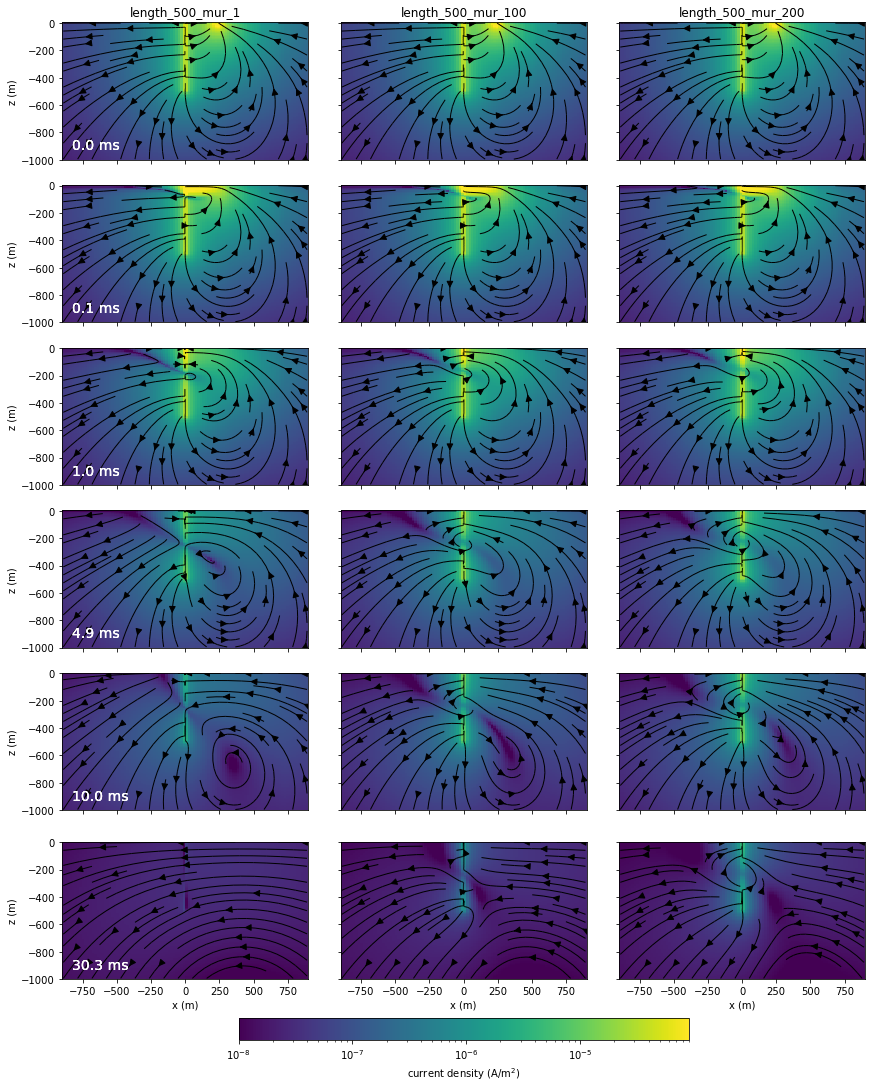

In [20]:
fig, ax = plt.subplots(
    len(time_inds), 3, 
    figsize=(12, len(time_inds)*2.5),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=900 * np.r_[-1, 1]
zlim=np.r_[-1000, 5]
clim = np.r_[1e-8, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}

plot_length = "500"
for j, key in enumerate([k for k in fields.keys() if plot_length in k]):
    f = fields[key]
    
    for i, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=14)
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# fig.savefig("figures/tdem-currents-cross-section-permeable", dpi=200, bbox_inches="tight")

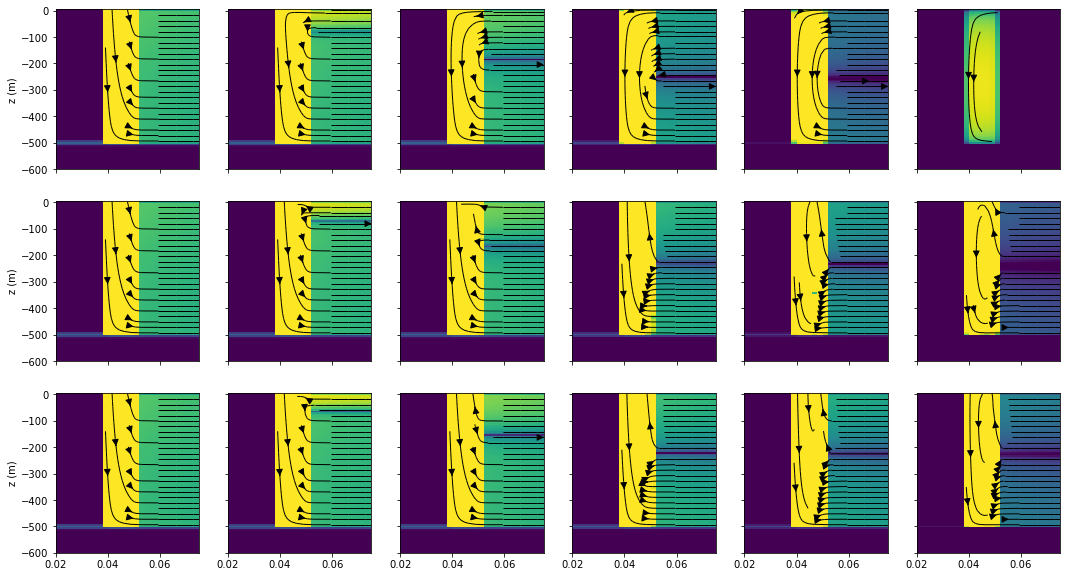

In [24]:
fig, ax = plt.subplots(
    3, len(time_inds),
    figsize=(len(time_inds)*3, 10),
    # constrained_layout=True,
    sharex=True, sharey=True, 
    # gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim= 0.1 * np.r_[-1, 1]
zlim=np.r_[-600, 5]
clim = np.r_[1e-5, 1e-1]

stream_opts={"color":"k", "density":1, "arrowsize":1.4, "linewidth":1}

plot_length = "500"
for i, key in enumerate([k for k in fields.keys() if plot_length in k]):
    f = fields[key]
    
    for j, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        # ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=14)
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)

# cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")

# fig.savefig("figures/tdem-currents-cross-section-permeable", dpi=200, bbox_inches="tight")

## Plot data 

In [25]:
models.keys()

dict_keys(['length_250_mur_1', 'length_250_mur_100', 'length_250_mur_200', 'length_500_mur_1', 'length_500_mur_100', 'length_500_mur_200', 'length_1000_mur_1', 'length_1000_mur_100', 'length_1000_mur_200', 'length_2000_mur_1', 'length_2000_mur_100', 'length_2000_mur_200'])

In [26]:
cell_centered_dbdt = {}

for key, val in fields.items():
    if key not in cell_centered_dbdt.keys():
        cell_centered_dbdt[key] = mesh.average_edge_to_cell_vector * val[:, "dbdt", :]

In [27]:
cell_centered_e = {}

for key, val in fields.items():
    if key not in cell_centered_e.keys():
        cell_centered_e[key] = mesh.average_face_to_cell_vector * val[:, "e", :]

In [28]:
def plot_primsec_cell_centered(data, plot_ind, primary_key, keys=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(3, 1, figsize=(7, 11.5), sharex=True) 
    primary = data[primary_key][plot_ind, :]
    
    if keys is None: 
        keys=data.keys()

    for i, key in enumerate(keys):
        val = data[key][plot_ind, :]

        diff = val - primary
        percent = diff / (np.abs(primary) + 1e-14) * 100

        ax[0].loglog(sim.times*1e3, np.abs(val), label=key, color=f"C{i}")
        ax[1].loglog(sim.times*1e3, np.abs(diff), label=key, color=f"C{i}")
        ax[2].loglog(sim.times*1e3, np.abs(percent), label=key, color=f"C{i}")

    for a in ax:
        a.grid()
    
    ax[2].set_xlabel("time (ms)")
    return ax


In [23]:
plot_spatial = {}

for key in models.keys():
    tmp = {}
    for ti in time_inds:
        primary = discretize.utils.mkvc(fields[get_primary_key(key)][:,'e', ti])
        total = discretize.utils.mkvc(fields[f"{key}"][:,'e', ti])
        tmp[ti] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/primary * 100
        }
    plot_spatial[key] = tmp

In [24]:
xlocs = np.r_[58, 62, 66]
mesh.nodes_x[xlocs]

array([100., 200., 300.])

In [25]:
zloc = -csz/2
theta_loc = 0

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.nodes_x[xl]) &
        (mesh.faces_x[:, 1] == mesh.cell_centers_y[theta_loc]) & 
        (mesh.faces_x[:, 2] == zloc)
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[100.           0.26179939  -2.5       ]
[200.           0.26179939  -2.5       ]
[ 3.00000000e+02  2.61799388e-01 -2.50000000e+00]


In [26]:
plot_timeseries = {}

for key in models.keys():
    tmp = {}
    for fi in face_inds:
        primary = discretize.utils.mkvc(fields[get_primary_key(key)][:, 'e', :][fi, :])
        total = discretize.utils.mkvc(fields[f"{key}"][:,'e', :][fi, :])
        tmp[fi] = {
            "total":total, 
            "primary":primary,
            "difference":total - primary,
            "percent":(total - primary)/np.abs(primary) * 100
        }
    plot_timeseries[key] = tmp

[Text(0.5, 1.0, '(a)'), Text(0.5, 1.0, '(b)')]

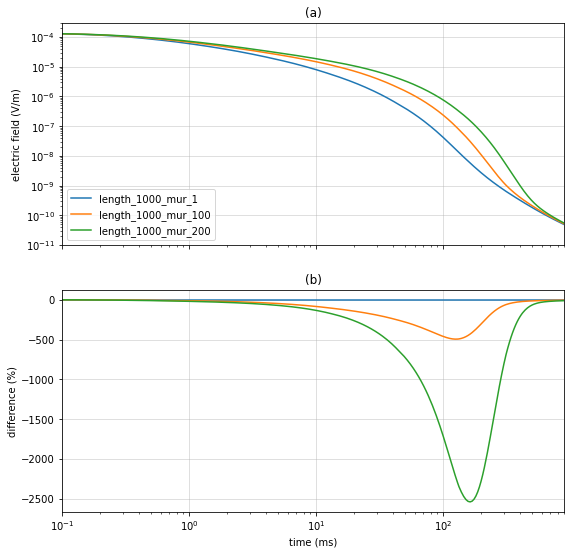

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(9, 9), sharex=True)
face_ind = 0

for key in list(plot_timeseries.keys())[6:9]:
    val = plot_timeseries[key][face_inds[face_ind]]
    legend = f"{key}"
    ax[0].loglog(sim.times*1e3, np.abs(val["total"]), label=legend)
    
    # ax[1].loglog(sim.times*1e3, diff, color=f"C{i}")
    ax[1].semilogx(sim.times*1e3, val["percent"])
    # ax_inset.semilogx(sim.times*1e3, diff/np.abs(primary), color=f"C{i}")
    
ax[0].set_xlim(1e-1, 9e2)
ax[0].set_ylim(1e-11, 3e-4)
ax[0].set_ylabel("electric field (V/m)")

# ax[1].set_ylabel("difference (V/m)")

# ax[1].set_ylim([-1, 100])
ax[1].set_ylabel("difference (%)")

# ax_inset.set_ylim([-1, 30])

for a in ax: 
    a.grid("both", alpha=0.5)
    
ax[1].set_xlabel("time (ms)")

ax[0].legend(loc=3)


[a.set_title(f"({letter})") for a, letter in zip(ax, ascii_lowercase)]

# if save_figures:
#     fig.savefig(f"{fig_dir_high}/motivation-e-fields.png", dpi=dpi_high)
#     fig.savefig(f"{fig_dir_low}/motivation-e-fields.png", dpi=dpi_low)

In [28]:
# cell_centered_dbdt = {}

for key, val in fields.items():
    if key not in cell_centered_dbdt.keys():
        cell_centered_dbdt[key] = mesh.average_edge_to_cell_vector * val[:, "dbdt", :]

NameError: name 'cell_centered_dbdt' is not defined

In [ ]:
zlocs = np.r_[415]
x_locs = np.r_[53, 58, 63]
print(mesh.cell_centers_z[zlocs])
print(mesh.cell_centers_x[x_locs])


In [ ]:
spatial_ind = np.where(
    (mesh.cell_centers[:, 0] == mesh.cell_centers_x[x_locs[0]]) &
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[0]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[zlocs[0]])
)[0][0]

spatial_ind_r = spatial_ind
spatial_ind_theta = spatial_ind + mesh.n_cells
spatial_ind_z = spatial_ind + 2*mesh.n_cells

print(mesh.cell_centers[spatial_ind, :])

In [ ]:
key.split("_")

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 11.5), sharex=True)

plot_ind = spatial_ind_theta
line_styles = ["-", "--", "-."]
for i, key in enumerate(cell_centered_dbdt.keys()):
    val = cell_centered_dbdt[key][plot_ind, :]
    primary = cell_centered_dbdt[get_primary_key(key)][plot_ind, :]
    diff = val - primary
    percent = diff / (np.abs(primary) + 1e-14) * 100
    
    color_ind = np.where(casing_l == int(key.split("_")[1]))[0][0]
    ls = line_styles[np.where(mur_casing == float(key.split("_")[-1]))[0][0]]
    
    ax[0].loglog(sim.times*1e3, np.abs(val), label=key, color=f"C{color_ind}", ls=ls)
    ax[1].loglog(sim.times*1e3, np.abs(diff), label=key, color=f"C{color_ind}", ls=ls)
    ax[2].loglog(sim.times*1e3, np.abs(percent), label=key, color=f"C{color_ind}", ls=ls)

for a in ax:
    a.grid()

ax[0].legend(bbox_to_anchor=[1, 1])
ax[0].set_ylim(np.r_[1e-15, 3e-3])
ax[1].set_ylim(np.r_[1e-15, 1e-7])
ax[2].set_ylim(np.r_[1e-3, 1e2]);

In [ ]:
lsind

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(7, 11.5), sharex=True)

plot_ind = spatial_ind_theta
line_styles = ["-", "--", "-."]
for i, key in enumerate(cell_centered_dbdt.keys()):
    val = cell_centered_dbdt[key][plot_ind, :]
    primary = cell_centered_dbdt[get_primary_key(key, "length")][plot_ind, :]
    diff = val - primary
    percent = diff / (np.abs(primary) + 1e-14) * 100
    
    color_ind = np.where(casing_l == int(key.split("_")[1]))[0][0]
    lsind = np.where(mur_casing == float(key.split("_")[-1]))[0][0]
    
    ax[0].loglog(sim.times*1e3, np.abs(val), label=key, color=f"C{color_ind}", ls=line_styles[lsind])
    ax[1].loglog(sim.times*1e3, np.abs(diff), label=key, color=f"C{color_ind}", ls=line_styles[lsind])
    ax[2].loglog(sim.times*1e3, np.abs(percent), label=key, color=f"C{color_ind}", ls=line_styles[lsind])

for a in ax:
    a.grid()

ax[0].legend(bbox_to_anchor=[1, 1])
ax[0].set_ylim(np.r_[1e-15, 3e-3])
ax[1].set_ylim(np.r_[1e-15, 1e-7])
ax[2].set_ylim(np.r_[1e-3, 1e2]);